In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
import xgboost as xgb #BDT
import pickle

from analysis import Optimization

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
babies = glob.glob("../analysis/studies/onelep/output/Run2/*.root")
babies = [baby for baby in babies if "data" not in baby]
babies

['../analysis/studies/onelep/output/Run2/Bosons.root',
 '../analysis/studies/onelep/output/Run2/WJets.root',
 '../analysis/studies/onelep/output/Run2/SingleTop.root',
 '../analysis/studies/onelep/output/Run2/TTbar2L.root',
 '../analysis/studies/onelep/output/Run2/VH.root',
 '../analysis/studies/onelep/output/Run2/TTX.root',
 '../analysis/studies/onelep/output/Run2/TTbar1L.root',
 '../analysis/studies/onelep/output/Run2/VBSWH_mkW.root']

In [3]:
vbswh = Optimization(
    sig_root_files=babies[-1:],
    bkg_root_files=babies[:-1],
    ttree_name="tree",
    weight_columns=["xsec_sf"]
)

In [4]:
vbswh.make_selection("M_jj > 1500 and abs(deta_jj) > 5 and ST > 500")
vbswh.set_split_column(ratio=0.75, name="split")

In [5]:
vbswh.df["abs_deta_jj"] = np.abs(vbswh.df.deta_jj)
vbswh.df.columns

Index(['lep_pdgID', 'lep_pt', 'lep_eta', 'lep_phi', 'LT', 'hbbjet_score',
       'hbbjet_pt', 'hbbjet_eta', 'hbbjet_phi', 'hbbjet_mass',
       'hbbjet_msoftdrop', 'xsec_sf', 'event', 'MET', 'ST', 'lep_sf',
       'lep_sf_up', 'lep_sf_dn', 'HT', 'n_jets_pt30', 'n_fatjets',
       'n_loose_b_jets', 'n_medium_b_jets', 'n_tight_b_jets', 'ld_vbs_jet_pt',
       'tr_vbs_jet_pt', 'M_jj', 'deta_jj', 'dR_jj', 'name', 'is_signal',
       'is_data', 'event_weight', 'split', 'split_weight', 'abs_deta_jj'],
      dtype='object')

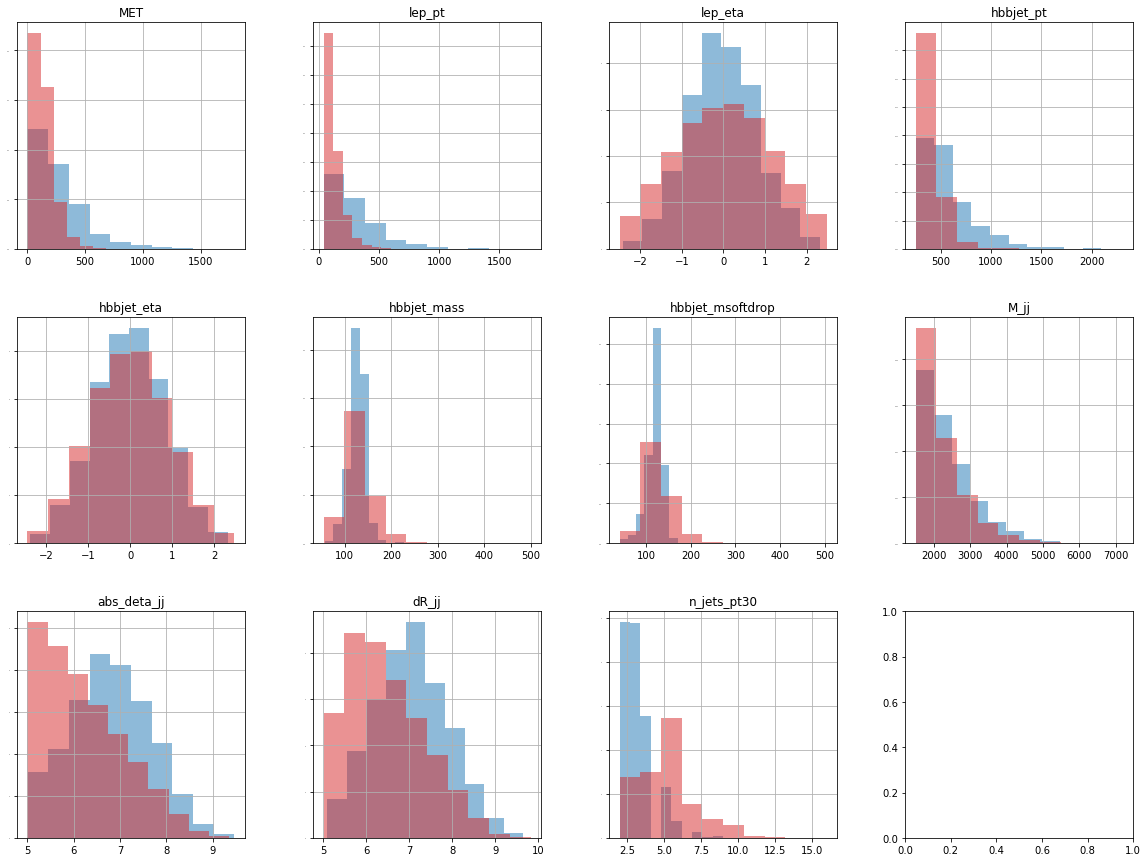

In [6]:
# # Select features
features = [
    "MET",
    "lep_pt",
    "lep_eta",
#     "hbbjet_score",
    "hbbjet_pt",
    "hbbjet_eta",
    "hbbjet_mass",
    "hbbjet_msoftdrop",
    "M_jj",
    "abs_deta_jj",
    "dR_jj",
    "n_jets_pt30"
]

# Plot feature shapes
fig, axes = plt.subplots(3,4,figsize=(20,15))

sig_df = vbswh.sig_df()
bkg_df = vbswh.bkg_df()

ax = sig_df[features].hist(
    ax=axes.flatten()[:len(features)],
    alpha=0.5, color="C0", ylabelsize=0, 
    density=True
)
ax = bkg_df[features].hist(
    ax=axes.flatten()[:len(features)], 
    alpha=0.5, color="C3", ylabelsize=0, 
    density=True
)

In [7]:
train_df = vbswh.df[vbswh.df.split].sample(frac=1.)
test_df = vbswh.df[~vbswh.df.split].sample(frac=1.)

# BDT Input
dtest = xgb.DMatrix(
    test_df[features], 
    label=test_df.is_signal,
    weight=np.abs(test_df.split_weight)
)
dtrain = xgb.DMatrix(
    train_df[features], 
    label=train_df.is_signal, 
    weight=np.abs(train_df.split_weight)
)
evallist = [(dtrain, "train"), (dtest, "eval")]

# BDT Parameters Setup
params = {}
params["objective"] = "binary:logistic"

# BDT Knobs (Parameters)
num_round = 500                  # Number of training rounds
params["eta"] = 0.1              # Step size shrinkage (alias: learning_rate)
params["max_depth"] = 3          # Max. depth of tree: larger = more complex = more prone to overfitting
params["verbosity"] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
params["nthread"] = 8            # Number of parallel threads
params["eval_metric"] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the Curve
params["subsample"] = 0.6        # Subsample ratio of the training instances
params["alpha"] = 8.0            # L1 regularization term on weights: Larger = more conservative
params["gamma"] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
params["lambda"] = 1.0           # L2 regularization term on weights: Larger = more conservative
params["min_child_weight"] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
params["colsample_bytree"] = 1.0 # The subsample ratio of columns when constructing each tree
# params["base_score"] = 0.1       # The initial prediction score of all instances, global bias

# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label() == 1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label() == 0]).sum()
# Control the balance of positive and negative weights, useful for unbalanced classes
# A typical value to consider: sum(negative instances) / sum(positive instances)
params["scale_pos_weight"] = sumw_neg/sumw_pos

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [8]:
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=True)

[0]	train-auc:0.87560	eval-auc:0.85674
[1]	train-auc:0.91639	eval-auc:0.90421
[2]	train-auc:0.92690	eval-auc:0.91384
[3]	train-auc:0.93082	eval-auc:0.91567
[4]	train-auc:0.93063	eval-auc:0.91727
[5]	train-auc:0.93459	eval-auc:0.91960
[6]	train-auc:0.93471	eval-auc:0.91991
[7]	train-auc:0.93623	eval-auc:0.92152
[8]	train-auc:0.93462	eval-auc:0.92068
[9]	train-auc:0.93926	eval-auc:0.92564
[10]	train-auc:0.94088	eval-auc:0.92774
[11]	train-auc:0.94200	eval-auc:0.92834
[12]	train-auc:0.94247	eval-auc:0.92890
[13]	train-auc:0.94242	eval-auc:0.92899
[14]	train-auc:0.94414	eval-auc:0.92982
[15]	train-auc:0.94438	eval-auc:0.93022
[16]	train-auc:0.94588	eval-auc:0.93158
[17]	train-auc:0.94680	eval-auc:0.93232
[18]	train-auc:0.94703	eval-auc:0.93284
[19]	train-auc:0.94709	eval-auc:0.93313
[20]	train-auc:0.94758	eval-auc:0.93356
[21]	train-auc:0.94785	eval-auc:0.93418
[22]	train-auc:0.94813	eval-auc:0.93481
[23]	train-auc:0.94818	eval-auc:0.93480
[24]	train-auc:0.94828	eval-auc:0.93506
[25]	train

In [9]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(train_df[features]))
preds_test = bst.predict(xgb.DMatrix(test_df[features]))

y_train = train_df.is_signal
y_test = test_df.is_signal

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


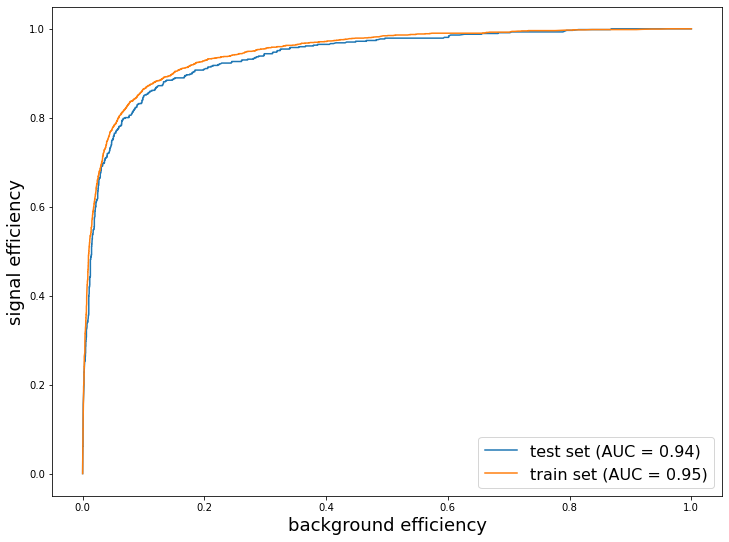

In [10]:
fig, axes = plt.subplots(figsize=(12,9))

# Test ROC Curve
fpr, tpr, thresh = roc_curve(test_df.is_signal, preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

# Train ROC Curve
fpr, tpr, thresh = roc_curve(train_df.is_signal, preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

plt.xlabel("background efficiency", size=18);
plt.ylabel("signal efficiency", size=18);
plt.legend(fontsize=16);

In [11]:
vbswh.df["bdt"] = bst.predict(xgb.DMatrix(vbswh.df[features]))

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<AxesSubplot:xlabel='BDT Score', ylabel='Events'>

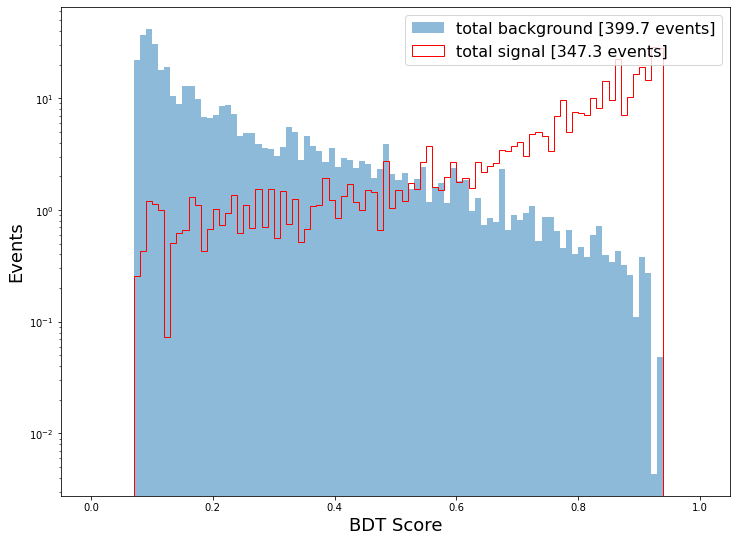

In [13]:
vbswh.plot_sig_vs_bkg("bdt", np.linspace(0, 1, 101), x_label="BDT Score", logy=True)

In [19]:
vbswh.fom_scan("bdt", [0.89,0.9,0.91,0.912,0.913,0.914,0.915,0.916,0.917,0.918])

sel,sig,bkg,fom
bdt > 0.89,106.95007313787937,0.8128960728445236,118.62154415909852
bdt > 0.9,90.55116255581379,0.7031429090457095,107.98718737931709
bdt > 0.91,71.57738084346056,0.32641549978689,125.2825014619476
bdt > 0.912,68.41939689964056,0.32553400087454065,119.9170852293737
bdt > 0.913,67.84181600064039,0.2785782575938356,128.53572627414658
bdt > 0.914,66.61577666550875,0.2785782575938356,126.21282477073858
bdt > 0.915,65.51333836466074,0.09188002443261212,216.132053285849
bdt > 0.916,64.0638886988163,0.050938227235747036,283.8516242687002
bdt > 0.917,63.70467188954353,0.050938227235747036,282.26002131034625
bdt > 0.918,57.786419942975044,0.05229353454342345,252.69799195794533


In [18]:
vbswh.fom_scan("hbbjet_score", [0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98], base_selection="bdt > 0.89")

sel,sig,bkg,fom
bdt > 0.89 and hbbjet_score > 0.91,106.29301603138447,0.7229815521222918,125.00895429303498
bdt > 0.89 and hbbjet_score > 0.92,104.92527596652508,0.6788330734652845,127.34990443796927
bdt > 0.89 and hbbjet_score > 0.93,103.34506606310606,0.39791094744032307,163.83127206647146
bdt > 0.89 and hbbjet_score > 0.94,101.83890914171934,0.30961399012630864,183.02206474879307
bdt > 0.89 and hbbjet_score > 0.95,100.50520142167807,0.2576252336093603,198.01328969129028
bdt > 0.89 and hbbjet_score > 0.96,98.50859642773867,0.2558274658458686,194.76035019080425
bdt > 0.89 and hbbjet_score > 0.97,94.34293723851442,0.21765000855702965,202.22276722694687
bdt > 0.89 and hbbjet_score > 0.98,91.1230516731739,0.1655883245930454,223.9305772606407


In [16]:
for key, val in params.items():
    print(f"{key},{val}")

objective,binary:logistic
eta,0.1
max_depth,3
verbosity,1
nthread,8
eval_metric,auc
subsample,0.6
alpha,8.0
gamma,2.0
lambda,1.0
min_child_weight,1.0
colsample_bytree,1.0
scale_pos_weight,1.188511610031128


In [17]:
# Write features list
with open("../analysis/studies/onelep/bdt_features.txt", "w") as txt_file:
    txt_file.write("\n".join(features))

# Write BDT model
pickle.dump(bst, open("../analysis/studies/onelep/bdt.pkl", "wb"))
bst.save_model("../analysis/studies/onelep/bdt.model")
bst.dump_model("../analysis/studies/onelep/bdt.json", "../analysis/studies/onelep/bdt_features.txt")